In [1]:
from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns
import pandas as pd
import scipy
import numpy as np
import corner

2024-03-21 17:18:50.859759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 17:18:50.859788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 17:18:50.860646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 17:18:50.866213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 17:18:51.386407: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
3368273,0.96,0.012797,0.28,1.9,5.280682,1.039252,1.092547,5792.673181,0.011242,633.01815,...,0.536662,0.537401,0.536518,0.536941,0.536839,0.535663,0.533404,0.5307,0.528837,0.528322


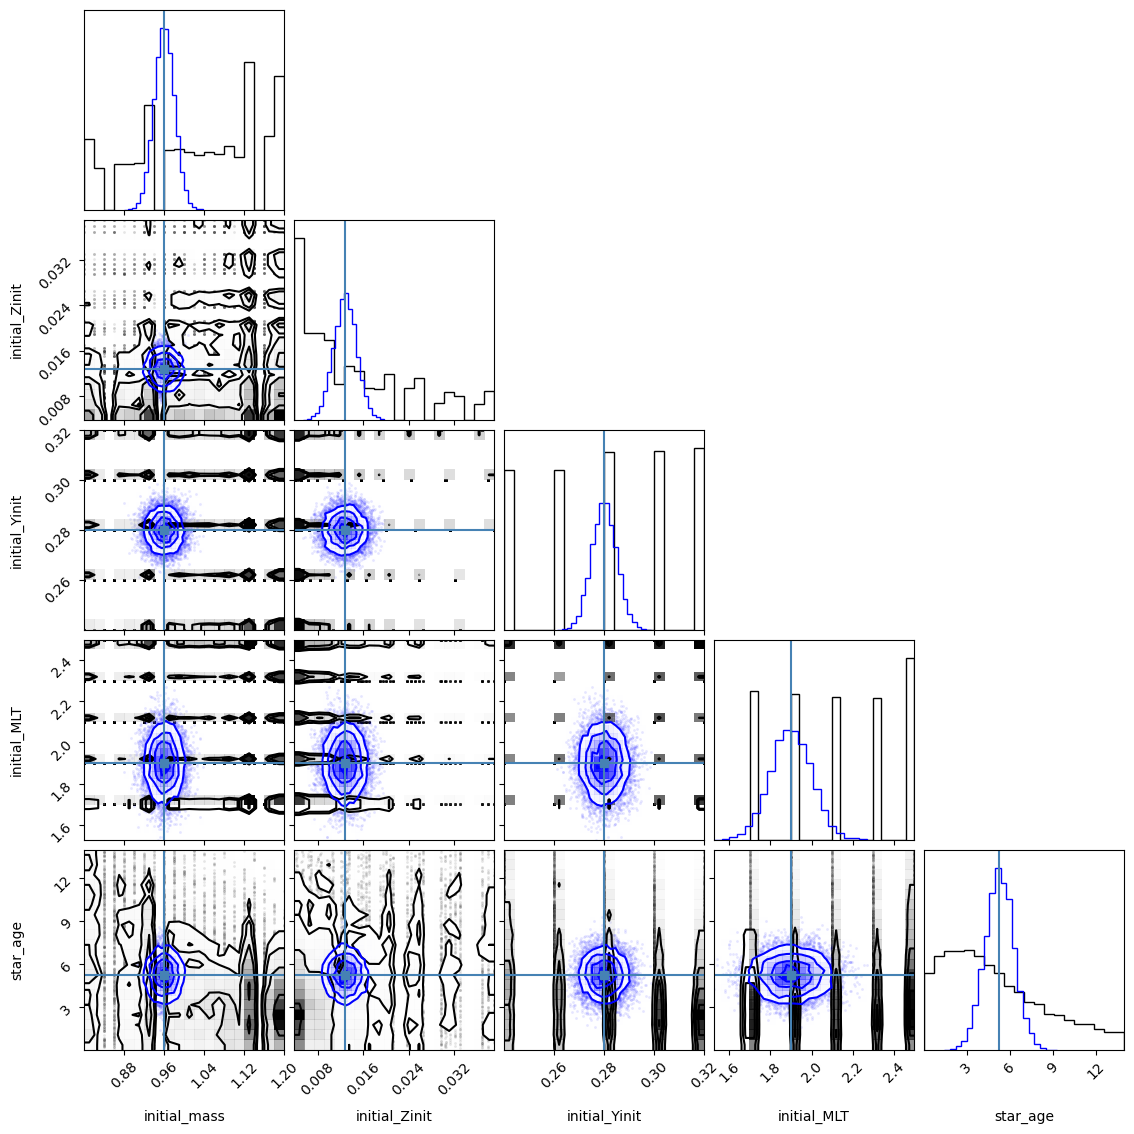

In [4]:
"""
Define priors
"""

def uniform_prior(model_inps, header, scale):
    return scipy.stats.uniform(loc=(1-scale)*model_inps[header], scale=(1+scale)*model_inps[header]-(1-scale)*model_inps[header])

def normal_prior(model_inps, header, scale):
    return scipy.stats.norm(loc=model_inps[header], scale=scale)

mass_prior = normal_prior(model_inps, "initial_mass", 0.02)

Zinit_prior = normal_prior(model_inps, "initial_Zinit", 0.002)

Yinit_prior = normal_prior(model_inps, "initial_Yinit", 0.005)

MLT_prior = normal_prior(model_inps, "initial_MLT", 0.1)

age_prior = normal_prior(model_inps, "star_age", 1)

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000));

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);

In [5]:
pitchfork = emulator("nu6-40")

2024-03-21 17:18:57.877283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17982 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-03-21 17:18:57.877787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [6]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values
unc = [.5, 1, 0.005] + [1.5+0.1*(np.abs(i-22))**2 for i in range(5,40)]
unc

[0.5,
 1,
 0.005,
 30.400000000000002,
 27.1,
 24.0,
 21.1,
 18.400000000000002,
 15.9,
 13.600000000000001,
 11.5,
 9.6,
 7.9,
 6.4,
 5.1,
 4.0,
 3.1,
 2.4,
 1.9,
 1.6,
 1.5,
 1.6,
 1.9,
 2.4,
 3.1,
 4.0,
 5.1,
 6.4,
 7.9,
 9.6,
 11.5,
 13.600000000000001,
 15.9,
 18.400000000000002,
 21.1,
 24.0,
 27.1,
 30.400000000000002]

In [14]:
%%time
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler()

corner.corner(posterior);

iter: 6983 | bound: 0 | nc: 1 | ncall: 28363 | eff(%): 24.620 | loglstar:   -inf < -152134.555 <    inf | logz: -152144.670 +/-  0.022 | dlogz: 152044.136 > 20.009                                   Traceback (most recent call last):
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/home/oxs235/repos/ojscutt/sl-pitchfork/pitchfuncs.py", line 129, in logl
    m = np.array(self.pitchfork.predict(np.array([theta])))
  File "/home/oxs235/repos/ojscutt/sl-pitchfork/pitchfuncs.py", line 105, in predict
    standardised_log_outputs = self.model.predict(standardised_log_inputs, verbose=verbose)
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/keras/src/engine

Exception while calling loglikelihood function:
  params: [0.96444053 0.0139537  0.28985965 1.88088847 5.32590379]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

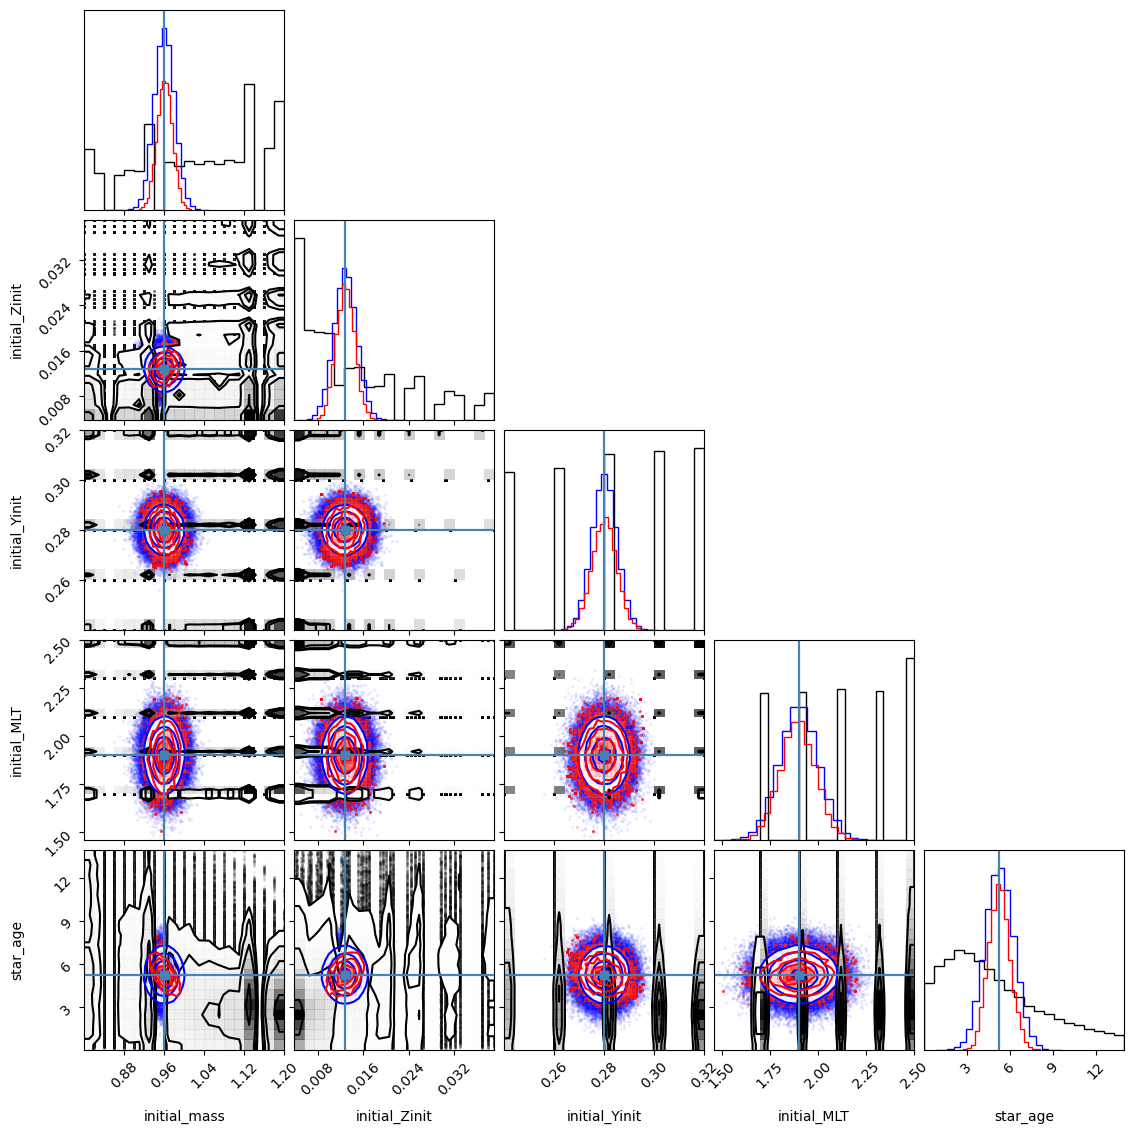

In [15]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));

prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

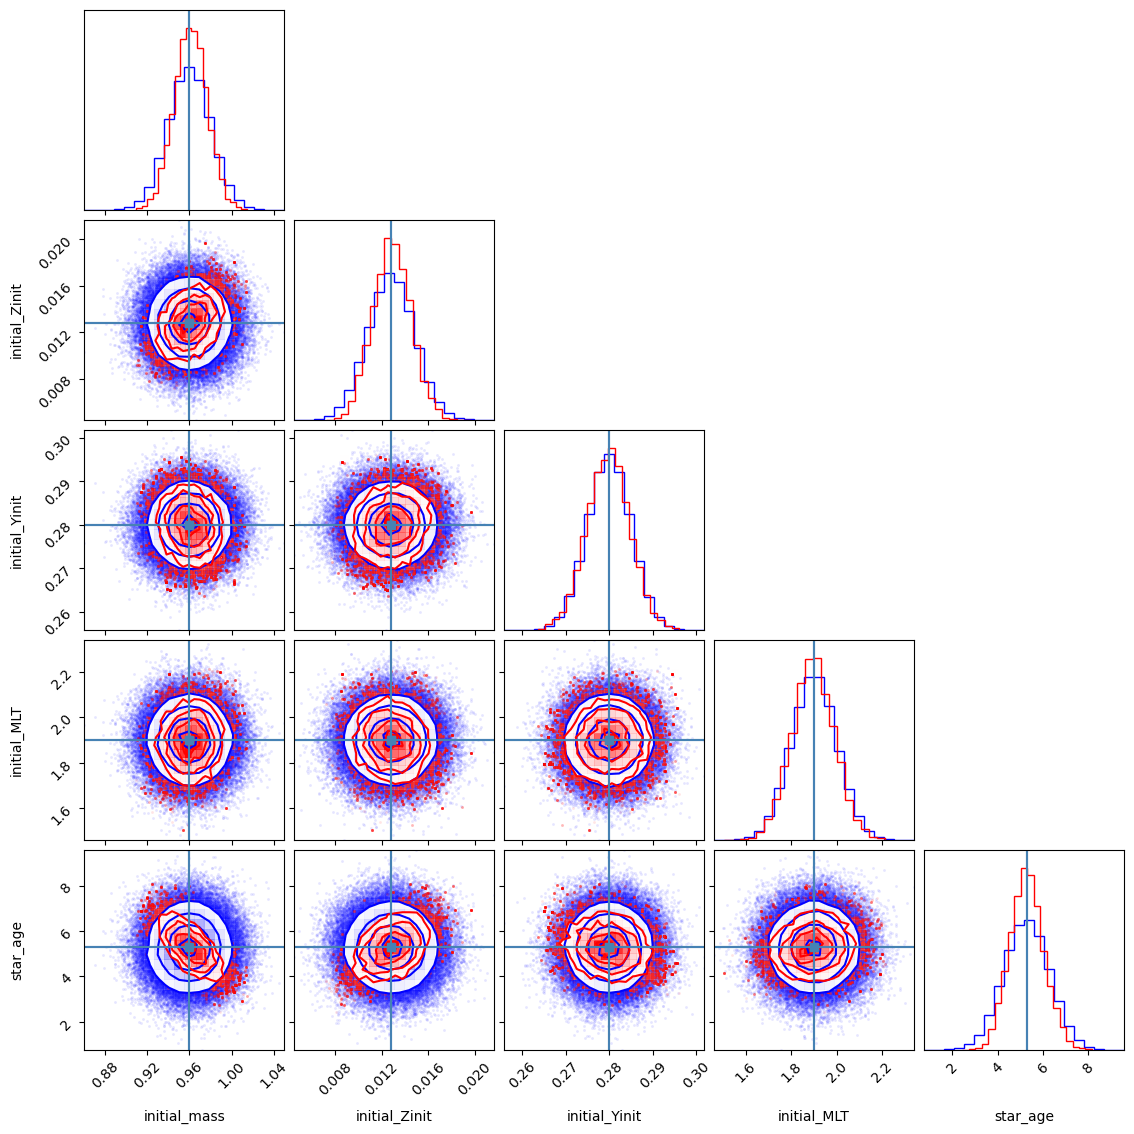

In [16]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

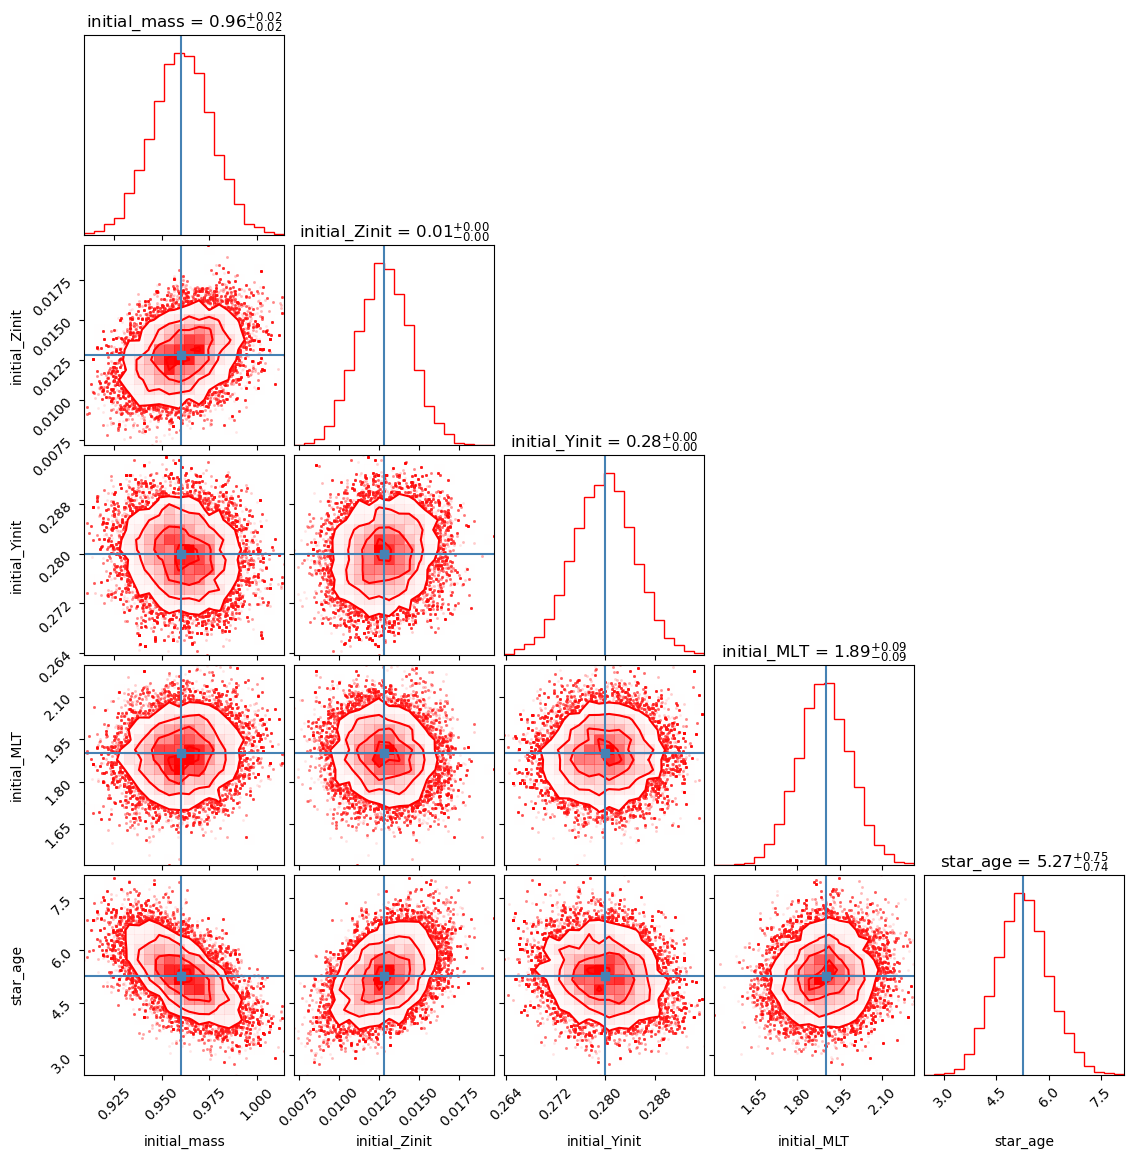

In [17]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True);